# ``VAE2d`` Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.VAE2d``, we use it to encode and decode MNIST images.

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter

from torch.utils.data import DataLoader

batch_size = 8


training_tfms = Compose(
    [
        ToTensor(),
        RandomRotation(180),
        ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    ]
)
valid_tfms = Compose([ToTensor()])


train_set = MNIST(
    root="/home/jim/storage/mnist/",
    train=True,
    download=True,
    transform=training_tfms,
)

print(f"There are {len(train_set)} training items.")
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

print(f"The image size is '{train_set[0][0].shape}'")

There are 60000 training items.
The image size is 'torch.Size([1, 28, 28])'


In this demo, we want bother with a validation loop during training, and will just use the validation set to do some inference at the end. Let's instantiate the model.

In [2]:
from torch.cuda import is_available
from torch_tools import VAE2d

DEVICE = "cuda" if is_available() else "cpu"

model = VAE2d(in_chans=1, input_dims=(28, 28), num_layers=3).to(DEVICE)

print(model)

VAE2d(
  (encoder): Encoder2d(
    (0): DoubleConvBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ConvBlock(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (0): ConvBlock(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
        (1): ConvBlock(
          (0): Conv2d(128, 128, k

Now, we set up the optimiser and loss function.

In [3]:
from torch.optim import Adam
from torch.nn import L1Loss

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = L1Loss()

And now we write our training loop.

In [4]:
from torch.nn import Module


def train_one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Adam,
    loss_func: L1Loss,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.train()
    running_loss = 0.0
    for batch, _ in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds, kl_div = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)


        (l1_loss + kl_div).backward()

        optimiser.step()

        running_loss += l1_loss.item()

    return running_loss / len(data_loader)

Now we can train the model.

In [5]:
from time import perf_counter

epochs = 5

metrics = {"loss": []}

for epoch in range(epochs):

    start = perf_counter()

    metrics["loss"].append(
        train_one_epoch(
            model,
            train_loader,
            optimiser,
            loss_func,
        )
    )

    stop = perf_counter()

    print(f"Epoch time : {stop - start:.6f}")

/home/jim/miniconda3/envs/torch-tools/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch time : 359.789097
Epoch time : 392.615343
Epoch time : 393.919076
Epoch time : 393.654549
Epoch time : 397.673063


{'loss': [0.04770228665446242, 0.02922194164743026, 0.025442669454216957, 0.02360406299568713, 0.02224663183738788]}


Text(0, 0.5, 'Loss')

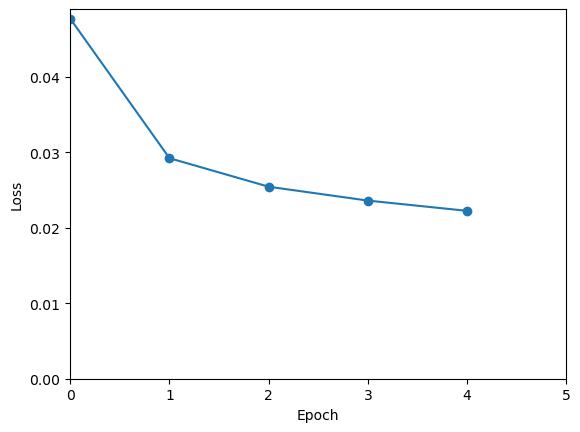

In [6]:
import matplotlib.pyplot as plt

print(metrics)

figure, axes = plt.subplots(1, 1)
axes.plot(metrics["loss"], "-o")

axes.set_ylim(bottom=0.0)
axes.set_xlim(left=0.0, right=epochs)

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

Now we can take a look at some predictions from the validation loader.


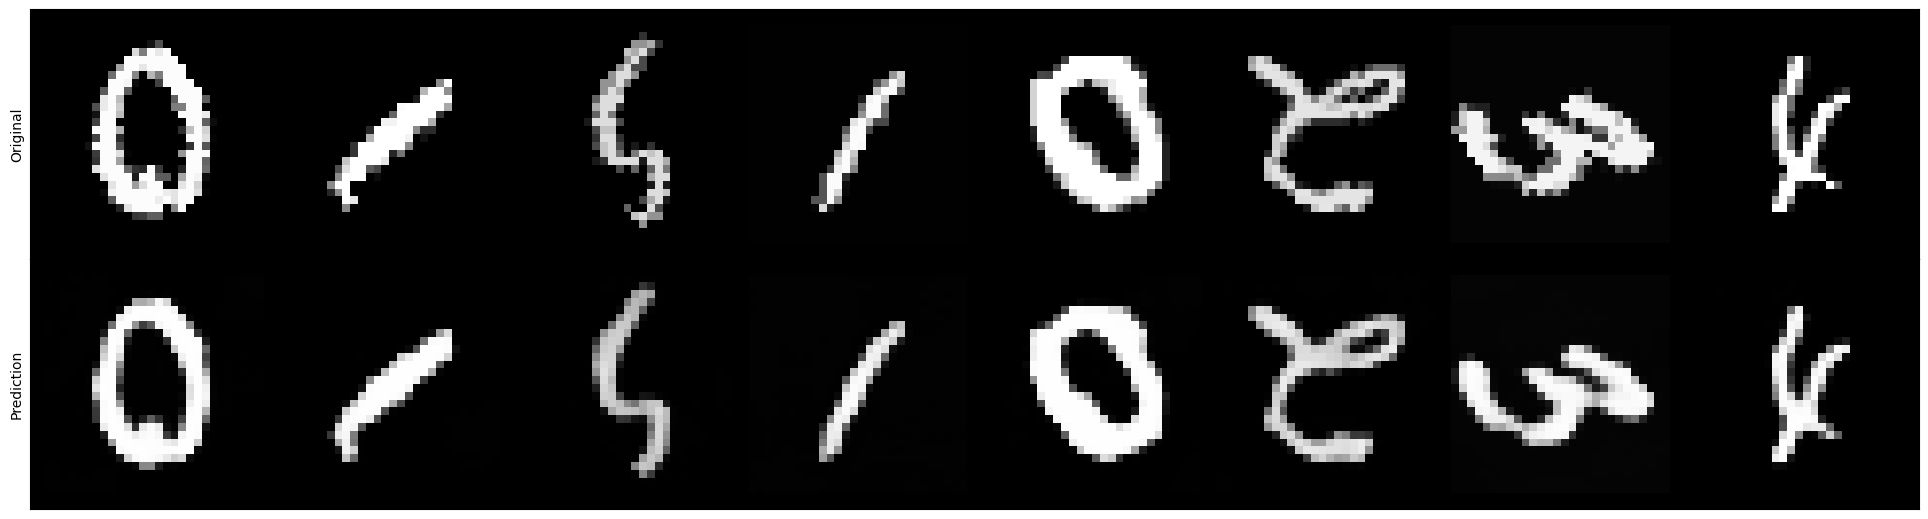

In [7]:
from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    for batch, target in train_loader:
        preds = model(batch.to(DEVICE)).tanh().clip(0.0, 1.0)
        break

batch_grid = make_grid(batch.cpu(), nrow=8, ncol=1).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=8, ncol=1).permute(1, 2, 0)


figure, axes = plt.subplots(2, 1, figsize=(20, 20 / 4))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_ylabel("Original")
axes[1].set_ylabel("Prediction")

figure.tight_layout(pad=0.01)